In [1]:
import pandas as pd
import numpy as np
import scipy.linalg as linalg
from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend, 
                           title, subplot, show, grid)
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
import array_to_latex as a2l
import seaborn as sns
import math
from matplotlib.pylab import figure, subplot, plot, xlabel, ylabel, hist, show
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import rlr_validate



df = pd.read_csv("../Prostate_Cancer.csv", index_col="id")
df["diagnosis_result"] = np.where(df["diagnosis_result"] == "M", 1, 0)

continuous_cols = ['radius', 
                    'texture', 
                    'perimeter', 
                    'area', 
                    'smoothness', 
                    'compactness', 
                    'symmetry', 
                    'fractal_dimension']
                    
df_means = df[continuous_cols].mean()

df_std = df[continuous_cols].std()

df[continuous_cols] = (df[continuous_cols] -  df_means) / df_std

X = df.to_numpy() # df as a numpy array

# Part A

In [2]:
# Field selected for regression:
target_column = "smoothness"

continuous_cols.remove(target_column)

y = df[target_column]
X = df[continuous_cols]

X = X.to_numpy()
y = y.to_numpy()

N, M = X.shape

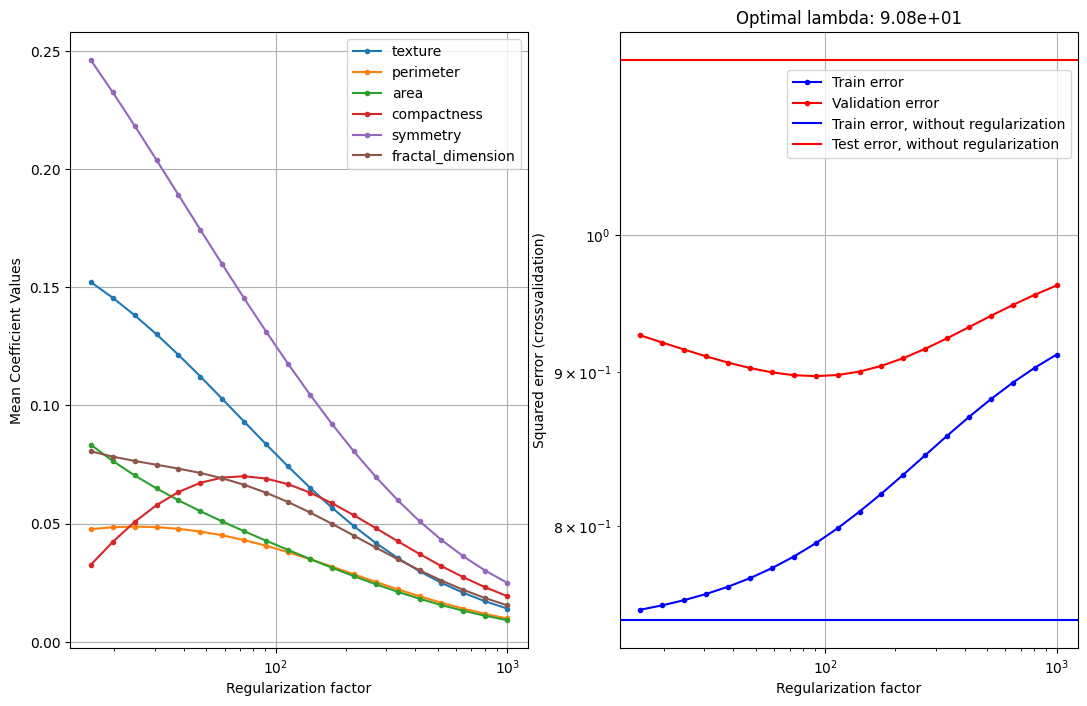

In [3]:
K = 5
CV = model_selection.KFold(K, shuffle=True, random_state=230)

lambdas = np.logspace(1.2, 3, num=20)

Error_train = np.empty((K,1))
Error_train_man = np.empty((K,1))
Error_test_man = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
opt_lambdas = np.empty((K,1))
error = np.empty((K,1))

w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))


model = lm.LinearRegression()

k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    error[k] = opt_val_err
    opt_lambdas[k] = opt_lambda
    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]
    Error_train_nofeatures = np.empty((K,1))
    Error_test_nofeatures = np.empty((K,1))

    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    model.fit(X_train, y_train)
    Error_train[k] = np.square(y_train-model.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-model.predict(X_test)).sum()/y_test.shape[0]
    Error_train_man[k] = np.square(y_train-(X_train @ np.linalg.solve(XtX, Xty))).sum()/y_train.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        figure(k, figsize=(13,8))
        subplot(1,2,1)
        semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        xlabel('Regularization factor')
        ylabel('Mean Coefficient Values')
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
        legend(continuous_cols[1:], loc='best')
        
        subplot(1,2,2)
        title('Optimal lambda: {0}'.format(np.format_float_scientific(opt_lambda, precision=2)))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        x1 = (90, Error_train[k, 0])
        x2 = (100, Error_train[k, 0])
        plt.axline(x1, x2, color='b')
        x1 = (90, Error_test[k, 0])
        x2 = (100, Error_test[k, 0])
        plt.axline(x1, x2, color='r')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Validation error',
                'Train error, without regularization', 'Test error, without regularization'],
                   bbox_to_anchor = [1, 0.95])
        grid()
    
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1

   

In [4]:
Error_test_rlr.mean()

0.8923044417719638

In [5]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [6]:
ann_scores_exploring = []

# for h in [1, 3, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]:

h = 5

lambdas = [*range(10, 100, 5)]

for l in lambdas:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=100)
    # Build the ANN model with h hidden units and λ regularization
    ann_model = MLPRegressor(hidden_layer_sizes=(h,), alpha=l, max_iter=5000, learning_rate_init=0.001, random_state=100)
    ann_model.fit(X_train, y_train)

    # Evaluate the ANN model
    ann_pred = ann_model.predict(X_test)

    ann_score = mean_squared_error(y_test, ann_pred)
    ann_scores_exploring.append(ann_score)

print(ann_scores_exploring)
print(lambdas)

[0.4403076957467631, 0.43145090596136004, 0.40185993554251687, 0.38673828292810286, 0.38187319323488655, 0.38062431203332253, 0.3808203196975598, 0.3821452095405865, 0.3840015826811102, 0.3861480067831369, 0.3878622778763231, 0.38973828049476633, 0.39360048131612535, 0.39806445850095423, 0.40365438544035664, 0.40787581071901313, 0.412090594957256, 0.41704418354663286]
[10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]


In [16]:
# Define your dataset (X and y)

# Define the number of folds
# N, M = X.shape

K1 = 3
K2 = 3

# Define the range of values for h (number of hidden units) and λ (regularization parameter)
hidden_units = [1, 5, 10, 20, 50]  # Example values for h
lambda_values = [150, 100, 50, 20, 10, 1, 0.1, 0.01]  # Example values for λ

# Initialize lists to store the results
regression_scores = np.empty((K1, 1))  # For regularized linear regression
ann_scores = np.empty((K1, 1))  # For artificial neural network
baseline_scores = np.empty((K1, 1))  # For the baseline model

best_lambdas = np.empty((K1, 1))
best_hs = np.empty((K1, 1))
best_ann_scores = np.empty((K1, 1))

linear_scores = np.empty((K1, 1))

w_rlr = np.empty((M,K1))
mu = np.empty((K1, M-1))
sigma = np.empty((K1, M-1))
w_noreg = np.empty((M,K1))


# Define two-level cross-validation
outer_cv = KFold(n_splits=K1, shuffle=True, random_state=42)

i = 0

for train_idx, test_idx in outer_cv.split(X, y):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # First, define a baseline model that predicts the mean of y
    baseline_model = DummyRegressor(strategy="mean")
    baseline_model.fit(X_train, y_train)
    baseline_pred = baseline_model.predict(X_test)
    baseline_score = mean_squared_error(y_test, baseline_pred)
    baseline_scores[i] = baseline_score

    # Second, implement two-level cross-validation for the ANN model
    inner_cv = KFold(n_splits=K2, shuffle=True, random_state=42)

    best_ann_score = float('inf')
    best_h = None
    best_lambda = None

    # linear model
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambda_values, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[i, :] = np.mean(X_train[:, 1:], 0)
    sigma[i, :] = np.std(X_train[:, 1:], 0)
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,i] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    linear_score_final = np.square(y_test-X_test @ w_rlr[:,i]).sum(axis=0)/y_test.shape[0]
    linear_scores[i] = linear_score_final

    # Loop through all hidden unit values and lambda values and perform KFold to find the best values
    for h in hidden_units:
        for lambda_value in lambda_values:

            ann_scores_inner = np.empty((K1, 1))

            for train_inner_idx, val_idx in inner_cv.split(X_train, y_train):
                X_train_inner, X_test_inner = X_train[train_inner_idx], X_train[val_idx]
                y_train_inner, y_test_inner = y_train[train_inner_idx], y_train[val_idx]

                # Build the ANN model with h hidden units and λ regularization
                ann_model = MLPRegressor(hidden_layer_sizes=(h,), alpha=lambda_value, max_iter=5000, learning_rate_init=0.001, random_state=100)
                ann_model.fit(X_train_inner, y_train_inner)

                # Evaluate the ANN model
                ann_pred = ann_model.predict(X_test_inner)

                ann_score = mean_squared_error(y_test_inner, ann_pred)
                ann_scores_inner[i] = ann_score

            mean_ann_score = np.mean(ann_scores_inner)

            # Check if previous KFold found best results
            if mean_ann_score < best_ann_score:
                best_ann_score = mean_ann_score
                best_h = h
                best_lambda = lambda_value

    best_lambdas[i] = best_lambda
    best_hs[i] = best_h

    # Train the ANN model on the entire training set of the fold with the best hyperparameters
    final_ann_model = MLPRegressor(hidden_layer_sizes=(best_h,), alpha=best_lambda, max_iter=5000, learning_rate_init=0.001, random_state=100)
    final_ann_model.fit(X_train, y_train)

    # Evaluate the final ANN model
    ann_pred_final = final_ann_model.predict(X_test)
    ann_score_final = mean_squared_error(y_test, ann_pred_final)
    ann_scores[i] = ann_score_final

    # Train and evaluate the regularized linear regression model
    ridge_model = Ridge(alpha=best_lambda)
    ridge_model.fit(X_train, y_train)
    ridge_pred = ridge_model.predict(X_test)
    ridge_score = mean_squared_error(y_test, ridge_pred)
    regression_scores[i] = ridge_score

    print("Fold: ", i+1 ,", ANN - h: ", best_h, "ANN - λ: ", best_lambda, ", ANN - E_test: ", round(ann_score_final, 4), ", Linear - λ: ", opt_lambda, ", Linear - E: ", round(linear_score_final, 4), ", Baseline - E: ", round(baseline_score, 4))


    i += 1



Fold:  1 , ANN - h:  1 ANN - λ:  20 , ANN - E_test:  0.6435 , Linear - λ:  100 , Linear - E:  0.766 , Baseline - E:  0.9936
Fold:  2 , ANN - h:  20 ANN - λ:  1 , ANN - E_test:  0.6345 , Linear - λ:  50 , Linear - E:  0.6824 , Baseline - E:  0.9145
Fold:  3 , ANN - h:  1 ANN - λ:  20 , ANN - E_test:  0.7726 , Linear - λ:  100 , Linear - E:  0.8703 , Baseline - E:  1.1241


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

best_score = 1 

for opt_lambda_ann in [0.01, 0.1, 1, 5, 10, 20, 40, 50, 100, 150]:
    for opt_h_ann in [1, 5, 10, 20, 40, 50, 100, 150]:

        best_ann_model = MLPRegressor(hidden_layer_sizes=(opt_h_ann,), alpha=opt_lambda_ann, max_iter=5000, learning_rate_init=0.001, random_state=100)
        best_ann_model.fit(X_train, y_train)

        yhatA = best_ann_model.predict(X_test)

        zA = np.abs(y_test - yhatA ) ** 2

        if zA.mean() < best_score:
            best_score = zA.mean()
            print("ANN E: ",  zA.mean(), ", λ: ", opt_lambda_ann, ", h: ", opt_h_ann)


ANN E:  0.5602004865690595 , λ:  0.01 , h:  1
ANN E:  0.4387381509363676 , λ:  0.01 , h:  5


In [79]:
from sklearn.model_selection import train_test_split
import numpy as np, scipy.stats as st

opt_h_ann = 5
opt_lambda_ann = 0.01

best_ann_model = MLPRegressor(hidden_layer_sizes=(opt_h_ann,), alpha=opt_lambda_ann, max_iter=5000, learning_rate_init=0.001, random_state=100)
best_ann_model.fit(X_train, y_train)

yhatA = best_ann_model.predict(X_test)

baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
    
yhatB = baseline_model.predict(X_test)# [:,np.newaxis]  #  justsklearnthings

# Linear regression
w_rlr = np.empty((M,K)) 

Xty = X_train.T @ y_train
XtX = X_train.T @ X_train
lambdaI = opt_lambda * np.eye(M)
lambdaI[0,0] = 0 # Do no regularize the bias term
w_rlr[:,i] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()

# Compute mean squared error with regularization with optimal lambda
zC =  np.square(y_test-X_test @ w_rlr[:,i])

# perform statistical comparison of the models
# compute z with squared error.
zA = np.abs(y_test - yhatA ) ** 2
# compute confidence interval of model A
alpha = 0.05

# Compute confidence interval of z = zA-zB and p-value of Null hypothesis
zB = np.abs(y_test - yhatB ) ** 2
z_A_B = zB - zA

CIA = st.t.interval(1-alpha, df=len(zB)-1, loc=np.mean(zB), scale=st.sem(zB))  # Confidence interval

CI = st.t.interval(1-alpha, len(z_A_B)-1, loc=np.mean(z_A_B), scale=st.sem(z_A_B))  # Confidence interval
p_ANN = st.t.cdf( -np.abs( np.mean(z_A_B) )/st.sem(z_A_B), df=len(z_A)-1)  # p-value


alpha = 0.05
CIA = st.t.interval(1-alpha, df=len(zB)-1, loc=np.mean(zB), scale=st.sem(zB))  # Confidence interval
z_C_B = zB - zC

CI = st.t.interval(1-alpha, len(z_C_B)-1, loc=np.mean(z_C_B), scale=st.sem(z_C_B))  # Confidence interval
p_LM = st.t.cdf( -np.abs( np.mean(z_C_B) )/st.sem(z_C_B), df=len(z_C_B)-1)  # p-value



# print(zA)
# print(zB)
# print(zC)
print()
print("ANN E: ",  zA.mean(), ", p: ", p_ANN, ", Avg improvement from baseline: ", z_A_B.mean())
print("Linear E: ",  zC.mean(), ", p: ", p_LM, ", Avg improvement from baseline: ", z_C_B.mean())
print("Baseline E: ", zB.mean())


ANN E:  0.658420444032209 , p:  0.19687158321336773 , Avg improvement from baseline:  0.2674964535672212
Linear E:  0.6093602651041655 , p:  0.04336786224247831 , Avg improvement from baseline:  0.31655663249526467
Baseline E:  0.9259168975994301
